In [122]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'
# mpl.rcParams['axes.aspect'] = 'equal'
%matplotlib inline
%config InlineBackend.figure_format='retina'


stretch = AsinhStretch()

Prepare data

In [110]:
IMG_DIR = '/quasar/data/GO1764/NIRCam/redux_v01/'

img_paths = []

# Load F250M data
for filename in os.listdir(IMG_DIR): 
    if 'jw01764001001_02101' in filename and 'nrcblong' in filename:
        img_paths.append(os.path.join(IMG_DIR, filename))

img_paths

['/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned.fits']

In [4]:
coord = SkyCoord("J100758.26+211529.2", unit=(u.hourangle, u.deg), frame='icrs')

coord

<SkyCoord (ICRS): (ra, dec) in deg
    (151.99275, 21.25811111)>

Image Cutout

In [5]:
def create_cutout_fits(fits_path, cutout_path, coord, radius):
    '''
    Parameters: 
        fits_path:      string
        output_path:    string
        coord:          SkyCoord
        radius:         float (in arcsec)
    '''
    with fits.open(fits_path) as hdul:
        # read file
        wcs = WCS(hdul['SCI'].header)
        data = hdul['SCI'].data
        pixel_scale = wcs.proj_plane_pixel_scales()[0].value # degrees per pixel
        print(pixel_scale)
        radius_pix = int(radius/3600/pixel_scale)
        size = (radius_pix*2, radius_pix*2)

        # Create the cutout
        cutout = Cutout2D(data, coord, size, wcs=wcs)
        hdul['SCI'].header.update(cutout.wcs.to_header())

        # Create new FITS HDUs
        new_hdul = fits.HDUList([fits.PrimaryHDU(header=hdul[0].header)])
        for hdu_name in ['SCI', 'ERR', 'DQ', 'AREA', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT']:
            if hdu_name in hdul:
                hdu_data = Cutout2D(hdul[hdu_name].data, coord, size, wcs=wcs)
                new_hdu = fits.ImageHDU(data=hdu_data.data, header=hdul[hdu_name].header, name=hdu_name)
                new_hdu.header.update(hdu_data.wcs.to_header())
                new_hdul.append(new_hdu)

        # Write the new cutout to a FITS file
        new_hdul.writeto(cutout_path, overwrite=False)
        print(f"Cutout saved to {cutout_path}")

In [116]:
radius = 2 # arcsec
cutout_dir = '/quasar/yichenliu/cutout'
cutout_paths = []
for fits_path in img_paths: 
    print(f'processing {fits_path}')
    directory = os.path.dirname(fits_path)
    filename = os.path.basename(fits_path)
    cutout_path = os.path.join(cutout_dir, filename[:-5]+'_cutout.fits')
    try: 
        create_cutout_fits(fits_path, cutout_path, coord, 2)
    except OSError as E: 
        print(f'ERROR: {E}')
    cutout_paths.append(cutout_path)
    # break

processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits
1.7456717745891736e-05
ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits
1.7456717725223197e-05
ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits
1.7456717706702727e-05


Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:22:57.306' from MJD-AVG.
Set DATE-END to '2023-05-10T02:26:32.041' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:31:32.634' from MJD-AVG.
Set DATE-END to '2023-05-10T02:35:07.369' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits
1.745671768573612e-05
ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned.fits
1.7456717667401716e-05


Set DATE-AVG to '2023-05-10T02:48:32.665' from MJD-AVG.
Set DATE-END to '2023-05-10T02:52:07.400' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:56:57.304' from MJD-AVG.
Set DATE-END to '2023-05-10T03:00:32.039' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned.fits
1.7456717646625574e-05
ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned.fits
1.7456717628004544e-05


Set DATE-AVG to '2023-05-10T03:05:32.632' from MJD-AVG.
Set DATE-END to '2023-05-10T03:09:07.367' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T01:57:32.636' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.371' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned.fits
1.745671760742824e-05
ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned.fits
1.745671776462474e-05
ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".


display cutouts

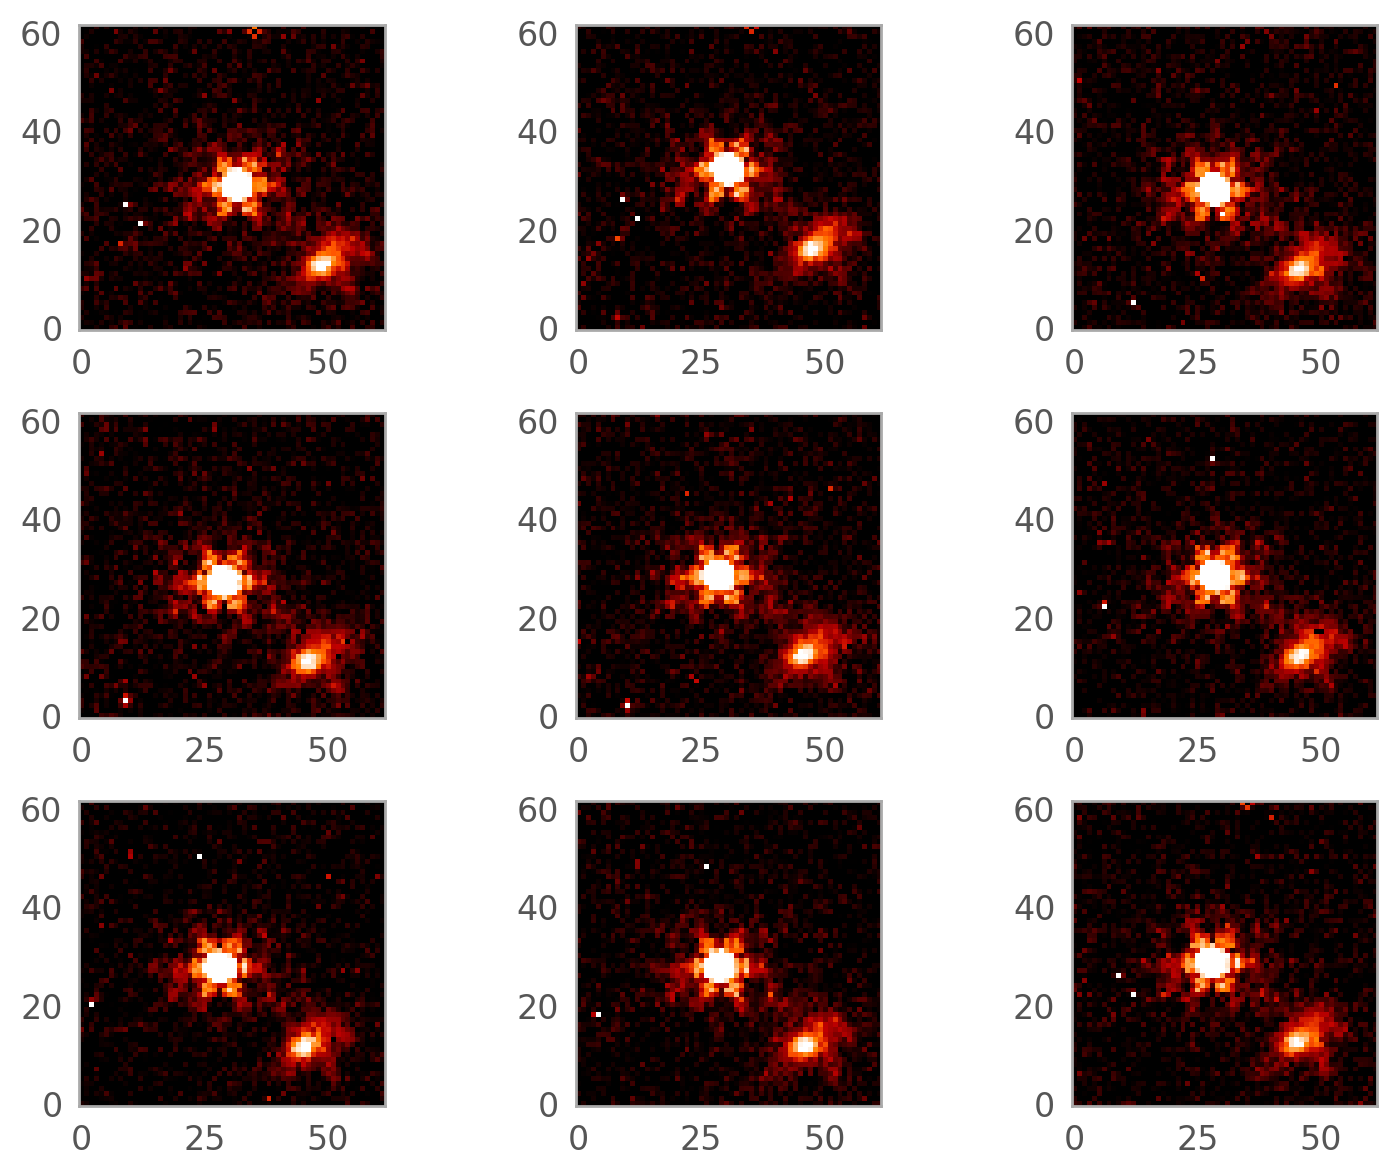

In [125]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul[1].data
        axs[i].imshow(stretch(data))
        axs[i].grid(False)

plt.tight_layout()

plot the position of central pixel

In [128]:
def get_pixel_center_coordinate(fits_path):
    with fits.open(fits_path) as hdul:
        wcs = WCS(hdul['SCI'].header)
        ny, nx = hdul['SCI'].data.shape
        center_x = (nx - 1) / 2
        center_y = (ny - 1) / 2
        sky_coord = wcs.pixel_to_world(center_x, center_y)
        return center_x, center_y, sky_coord

In [133]:
center_coords = []
for cutout_path in cutout_paths: 
    center_coord = get_pixel_center_coordinate(cutout_path)[2]
    center_coords.append(center_coord)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.948247 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540268792.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 

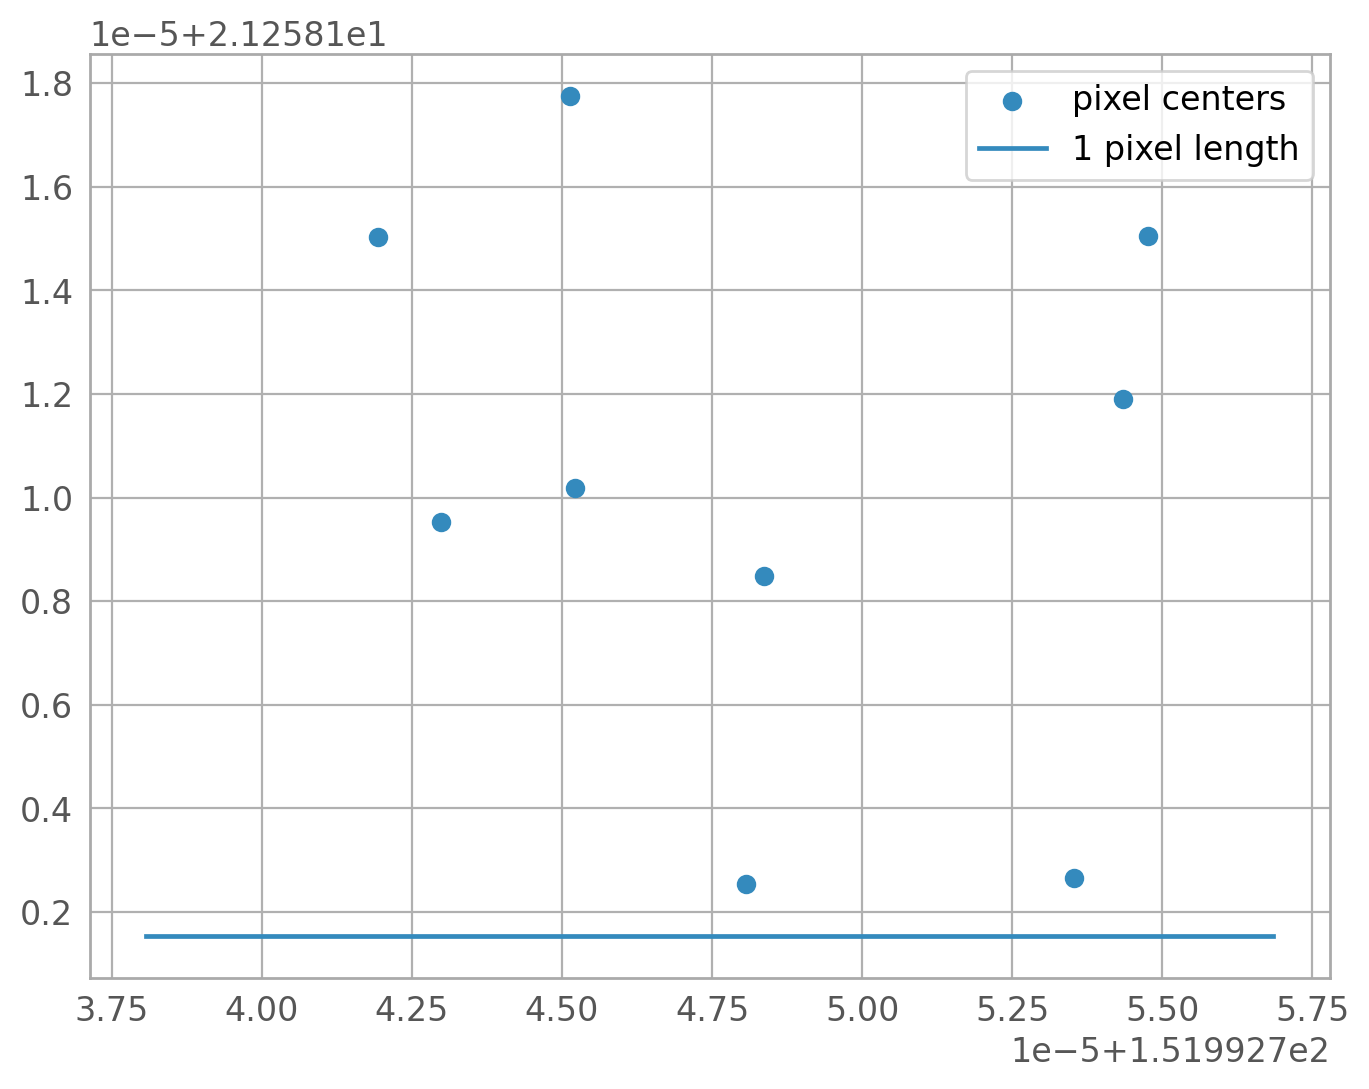

In [148]:
ra = SkyCoord(center_coords).ra.deg
dec = SkyCoord(center_coords).dec.deg

plt.scatter(ra, dec, label='pixel centers')

ra0  = ra[0]-1e-5
dec0 = dec[0]-1e-6
pixel_scale = 0.063/3600 # deg/pixel
plt.plot([ra0, ra0+pixel_scale/np.cos(np.deg2rad(dec0))], [dec0, dec0], label='1 pixel length')

plt.legend(loc='upper right')

In [7]:
import os

def get_file_sizes(file_list):
    sizes = {}
    for file_path in file_list:
        try:
            size = os.path.getsize(file_path)
            sizes[file_path] = size
        except FileNotFoundError:
            sizes[file_path] = "File not found"
        except Exception as e:
            sizes[file_path] = str(e)
    return sizes

# Example usage
file_list = img_paths
file_sizes = get_file_sizes(file_list)
for file_path, size in file_sizes.items():
    print(f"{file_path}: {size} bytes")


/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/

In [8]:



hdu = fits.open(cutout_path)

plt.imshow(stretch(hdu[1].data))

FileNotFoundError: [Errno 2] No such file or directory: '/quasar/yichenliu/cutout/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned_cutout.fits'

In [9]:
img_paths

['/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO176

Set DATE-AVG to '2023-05-10T02:05:57.403' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.138' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T01:57:32.764' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.499' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.731' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.466' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs

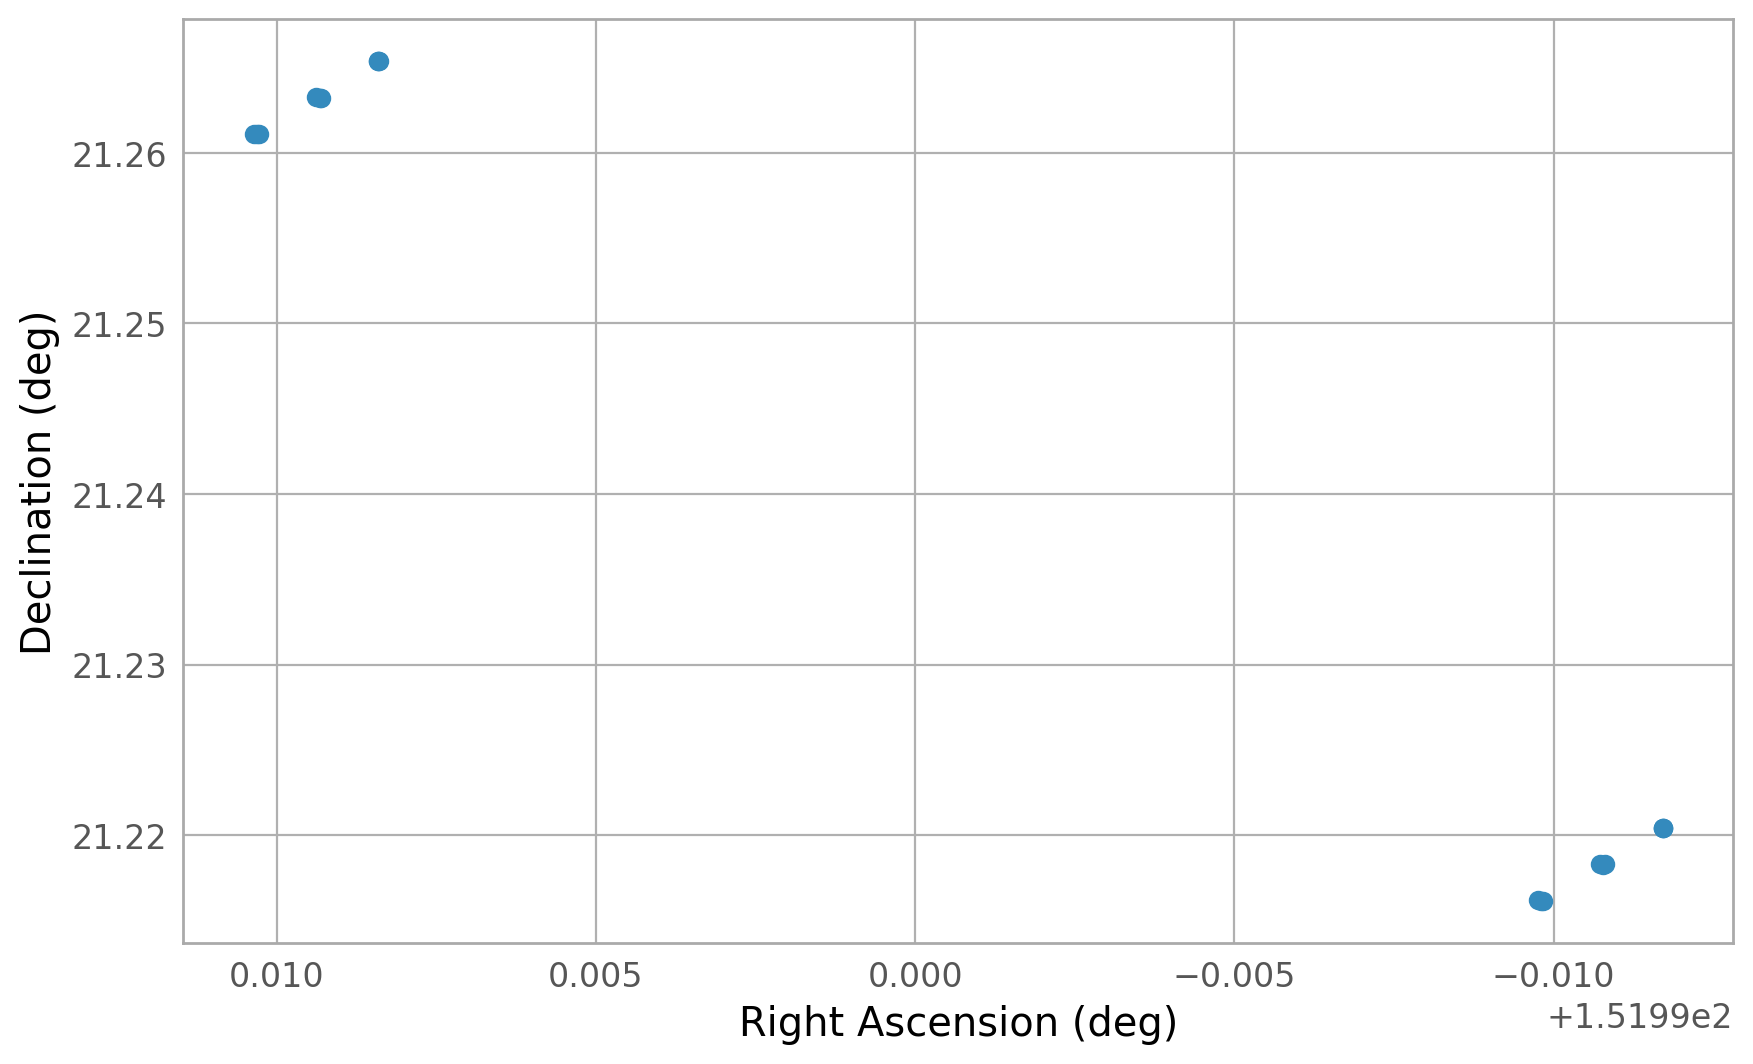

In [10]:
def get_pixel_center_coordinate(fits_path):
    # Open the FITS file
    with fits.open(fits_path) as hdul:
        # Get the WCS from the 'SCI' extension
        wcs = WCS(hdul['SCI'].header)
        
        # Get the dimensions of the image
        ny, nx = hdul['SCI'].data.shape
        
        # Calculate the center pixel coordinates
        center_x = (nx - 1) / 2
        center_y = (ny - 1) / 2
        
        # Convert pixel coordinates to sky coordinates
        sky_coord = wcs.pixel_to_world(center_x, center_y)
        
        return center_x, center_y, sky_coord

skycoords = []
for fits_path in img_paths: 
    center_x, center_y, sky_coord = get_pixel_center_coordinate(fits_path)
    skycoords.append(sky_coord)
# print(f"Sky coordinates at center: {sky_coord}")


ra = [coord.ra.deg for coord in skycoords]
dec = [coord.dec.deg for coord in skycoords]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(ra, dec)
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.gca().invert_xaxis()  # RA increases to the left
plt.grid(True)

plt.plot()
plt.show()

In [81]:
len(img_paths)

18

Set DATE-AVG to '2023-05-10T02:05:57.403' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.138' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T01:57:32.764' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.499' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.731' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.466' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs

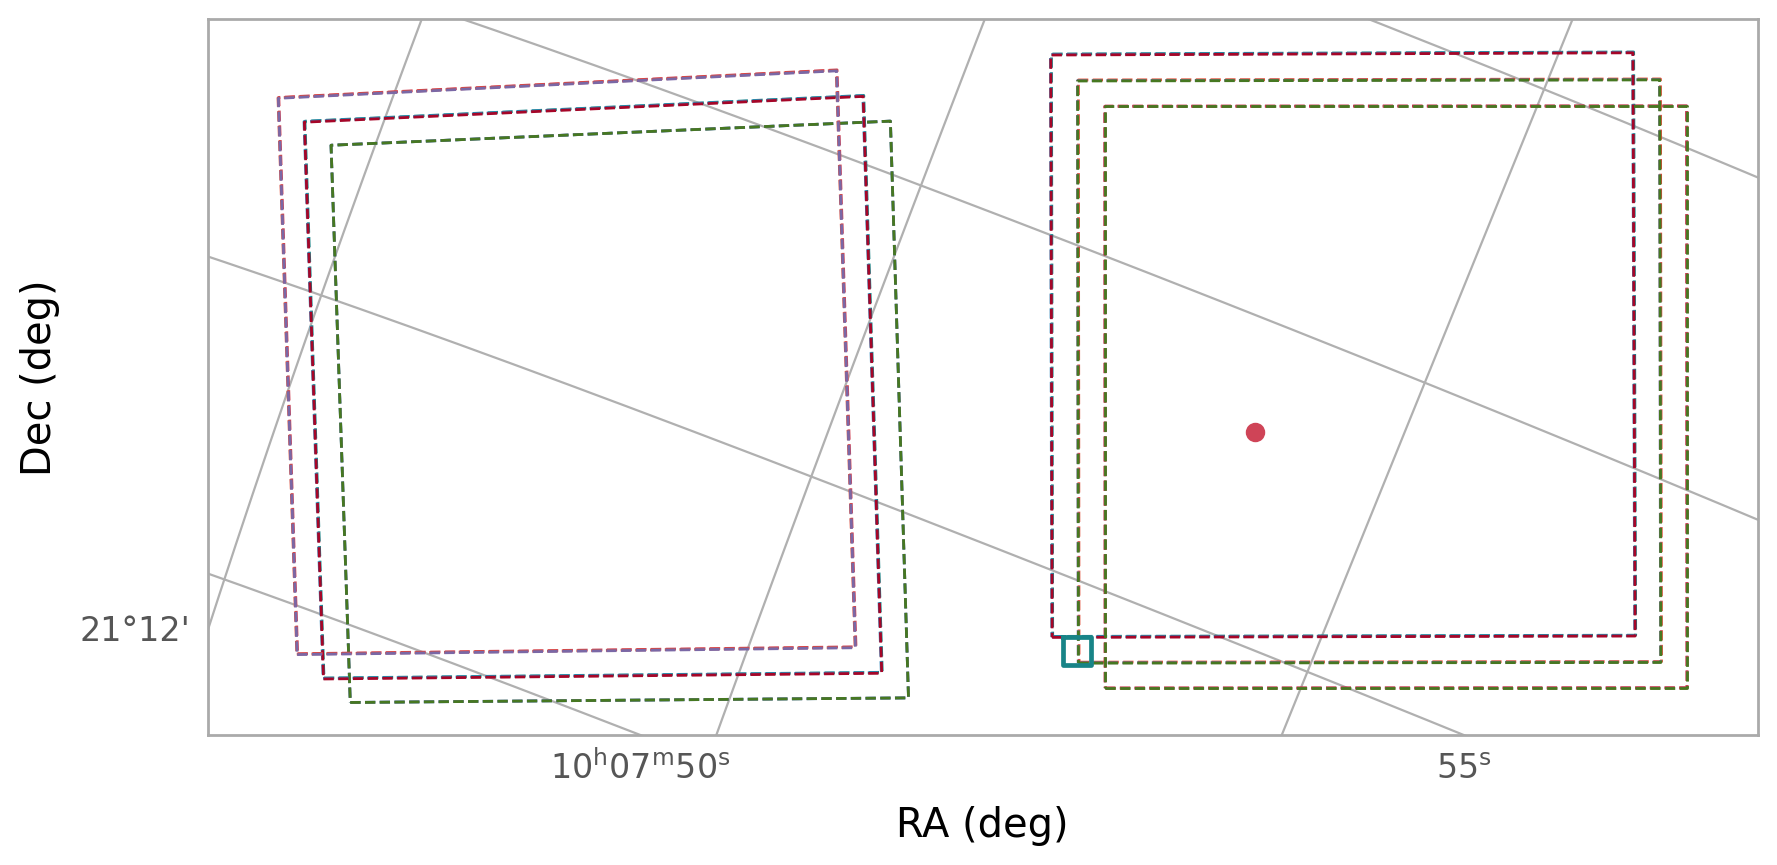

In [106]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection=wcs)
ax.set_aspect('equal')

# Load the FITS file
for filename in img_paths: 
    hdulist = fits.open(filename)
    wcs = WCS(hdulist[1].header)

    # Get the shape of the data array
    data_shape = hdulist[1].data.shape

    # Define the pixel coordinates of the corners
    corners = np.array([[0, 0],                    # Bottom-left
                        [0, data_shape[1]-1],      # Bottom-right
                        [data_shape[0]-1, 0],      # Top-left
                        [data_shape[0]-1, data_shape[1]-1]])  # Top-right

    # Convert pixel coordinates to world coordinates
    world_coords = wcs.pixel_to_world(corners[:, 1], corners[:, 0])

    ra = world_coords.ra.deg
    dec = world_coords.dec.deg

    plt.plot(ra[[0, 1, 3, 2, 0]], dec[[0, 1, 3, 2, 0]], linestyle='--', linewidth=1, 
             label=filename[30:40], transform=ax.get_transform('world'))

plt.plot(coord.ra.deg, coord.dec.deg, transform=ax.get_transform('world'), marker='o')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

x=-150
y=80
r=100
plt.plot([x, x+r, x+r, x, x], [y+r, y+r, y, y, y+r])
# plt.xlim(x, x+r)
# plt.ylim(y, y+r)
# plt.legend()
plt.grid(True)
plt.show()

In [61]:
ra, dec

array([151.97307029, 151.98781323, 152.00924205, 152.02337491])

In [62]:
coord.ra.deg

151.99275

In [13]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 0.0 0.0 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 1.0 1.0 
NAXIS : 0  0

In [17]:
hdulist.info()

Filename: /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     361   ()      
  1  SCI           1 ImageHDU       118   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [33801B]   


In [19]:
hdulist[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    60074.08498457407 / [d] exposure start time in MJD                 
MJD-AVG =     60074.0874699375 / [d] exposure mid-point in MJD                  
MJD-END =    60074.08995530093 / [d] exposure end time in MJD                   
TDB-BEG =    60074.08365043581 / [d] TDB time of exposure start in MJD          
TDB-MID =    60074.086135567